In [1]:
import os
os.environ['LIWC_PATH'] = "data/LIWC.json"
os.environ['OPENBLAS_NUM_THREADS'] = '1'
from os.path import join, dirname
import sys
sys.path.append('../')

from functools import partial

import numpy as np
from scipy import sparse as sp
import numba as nb
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, QuantileTransformer

from lyricpsych.utils import (load_csr_data,
                              split_recsys_data,
                              slice_row_sparse,
                              prepare_feature,
                              get_all_comb)
from lyricpsych.tasks.fm import *
from lyricpsych.tasks.als_feat import *
from lyricpsych.tasks.recsys import UserKNN, build_user_profile
from lyricpsych.utils import split_recsys_data, slice_row_sparse
from lyricpsych.metrics import ndcg

from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
from tqdm import tqdm


def load_data(recsys_data_fn, text_feat_data_fn):
    """"""
    print('Loading data...')
    X, users, items = load_csr_data(recsys_data_fn)
    item_hash_rec_data = {tid:j for j, tid in enumerate(items)}
    feature, track2id, pca, sclr, feature_sets = prepare_feature(text_feat_data_fn)
    
    mutual_tid = [tid for tid in items if tid in track2id]
    ix = [track2id[i] for i in mutual_tid]
    Y = np.concatenate(
        [feat[ix] for k, feat in feature.items()],
        axis=1
    )
    
    sclr = StandardScaler()
    # sclr = QuantileTransformer()
    Y = sclr.fit_transform(Y)
    mut_tid_set = set(mutual_tid)
    targets = [item_hash_rec_data[tid] for tid in mutual_tid]
    X2 = X[:, targets]
    return X2, Y, users, mutual_tid

In [2]:
# HERE WE LOAD DATA
root = '/home/jaykim/Documents/workbench/lyricpsych/'
recsys_data_fn = join(root, 'data/recsys_data.h5')
text_feat_data_fn = join(root, 'data/text_feat_test.h5')
X, Y, users, items = load_data(recsys_data_fn, text_feat_data_fn)

print('Splitting the data...')
Xtr, Xvl, Xts = split_recsys_data(X, train_ratio=0.8, valid_ratio=0.1)

Loading data...
Splitting the data...


In [3]:
mf = ALSFeat(32, lmbda=Xtr.sum()/10)
mf.fit(Xtr, Y[:, 240:], Xvl, verbose=True)

[vacc=0.0483]: 100%|████████████████████████████| 15/15 [07:16<00:00, 29.11s/it]


In [14]:
U = mf.embeddings_['user']
V = mf.embeddings_['item']
W = mf.embeddings_['feat']
Y_ = Y[:, 240:]
L = ((V - Y_ @ W)**2).sum()
print(L)

12.779678824230423


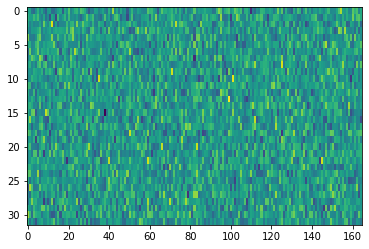

In [15]:
plt.imshow(W.T, aspect='auto')

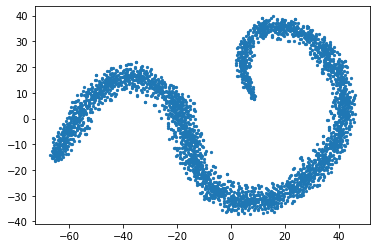

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
z2 = tsne.fit_transform(U[np.random.choice(U.shape[0], 3000, False)])
plt.scatter(z2[:, 0], z2[:, 1], s=5)

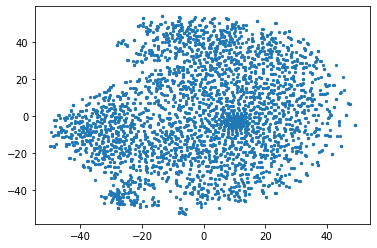

In [17]:
z2 = tsne.fit_transform(V[np.random.choice(V.shape[0], 3000, False)])
plt.scatter(z2[:, 0], z2[:, 1], s=5)

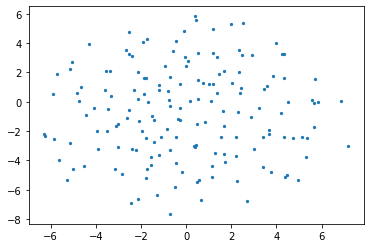

In [18]:
z2 = tsne.fit_transform(W)
plt.scatter(z2[:, 0], z2[:, 1], s=5)